# Credit Card Prediction

## Imports

In [1]:
import os

%matplotlib inline
import string
import sys
import mglearn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
simplefilter("ignore")

Based on the given information (ID, amount of given credit, sex, education, marriage, age, repayment status, amount of bill statement, and amount of previos pay), we are to determine if a client will default or not. 

There are some features that go by a specific scale such as repayment status (-1...9), education (1...6), marriage (1...3), and sex (1,2). 

Useful details about specific features:
- PAY_0...PAY_6: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
- BILL_AMT1...BILL_AMT6:  Amount of bill statement in September, 2005 to April, 2005 (NT dollar).
- PAY_AMT1...PAY_AMT6:  Amount of previous payment in September, 2005 to April, 2005 (NT dollar).

In [2]:
default_df = pd.read_csv('data/UCI_Credit_Card.csv')

default_df.SEX = default_df.SEX.astype("category")
default_df.EDUCATION = default_df.EDUCATION.astype("category")
default_df.MARRIAGE = default_df.MARRIAGE.astype("category")

default_df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


### Data cleansing

In [3]:
default_df.rename(columns={'PAY_0':'PAY_1'}, inplace = True)

def replace_6(x):
    return 5 if x == 6 else x

default_df['EDUCATION'] = default_df['EDUCATION'].apply(replace_6)
default_df = default_df.drop(columns=['ID'])

default_df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000.0,1,3,1,39,0,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,150000.0,1,3,2,43,-1,-1,-1,-1,0,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,30000.0,1,2,2,37,4,3,2,-1,0,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,80000.0,1,3,1,41,1,-1,0,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


<!-- BEGIN QUESTION -->

## Data splitting
<hr> 

In [4]:
train_df, test_df = train_test_split(default_df, test_size=0.3, random_state=123)

## EDA <a name="3"></a>
<hr>

In [5]:
default_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   LIMIT_BAL                   30000 non-null  float64 
 1   SEX                         30000 non-null  category
 2   EDUCATION                   30000 non-null  int64   
 3   MARRIAGE                    30000 non-null  category
 4   AGE                         30000 non-null  int64   
 5   PAY_1                       30000 non-null  int64   
 6   PAY_2                       30000 non-null  int64   
 7   PAY_3                       30000 non-null  int64   
 8   PAY_4                       30000 non-null  int64   
 9   PAY_5                       30000 non-null  int64   
 10  PAY_6                       30000 non-null  int64   
 11  BILL_AMT1                   30000 non-null  float64 
 12  BILL_AMT2                   30000 non-null  float64 
 13  BILL_AMT3       

- The dataset has no null values.
- All features are numeric (either an int or a float), not all of them are quantitative. Sex, education, marriage, and default.payment.next.month are all qualitative.
- Oridnal: education, marriage, PAY_0...PAY_6
- Numerical: BILL_AMT1...BILL_AM6, PAY_AMT1...PAY_AMT6 

In [6]:
default_df.describe()

,LIMIT_BAL,EDUCATION,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.851433,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.782463,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,5.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


- ID does not seem to have any valuable information

array([[<AxesSubplot: title={'center': 'LIMIT_BAL'}>,
        <AxesSubplot: title={'center': 'EDUCATION'}>,
        <AxesSubplot: title={'center': 'AGE'}>,
        <AxesSubplot: title={'center': 'PAY_1'}>,
        <AxesSubplot: title={'center': 'PAY_2'}>],
       [<AxesSubplot: title={'center': 'PAY_3'}>,
        <AxesSubplot: title={'center': 'PAY_4'}>,
        <AxesSubplot: title={'center': 'PAY_5'}>,
        <AxesSubplot: title={'center': 'PAY_6'}>,
        <AxesSubplot: title={'center': 'BILL_AMT1'}>],
       [<AxesSubplot: title={'center': 'BILL_AMT2'}>,
        <AxesSubplot: title={'center': 'BILL_AMT3'}>,
        <AxesSubplot: title={'center': 'BILL_AMT4'}>,
        <AxesSubplot: title={'center': 'BILL_AMT5'}>,
        <AxesSubplot: title={'center': 'BILL_AMT6'}>],
       [<AxesSubplot: title={'center': 'PAY_AMT1'}>,
        <AxesSubplot: title={'center': 'PAY_AMT2'}>,
        <AxesSubplot: title={'center': 'PAY_AMT3'}>,
        <AxesSubplot: title={'center': 'PAY_AMT4'}>,
     

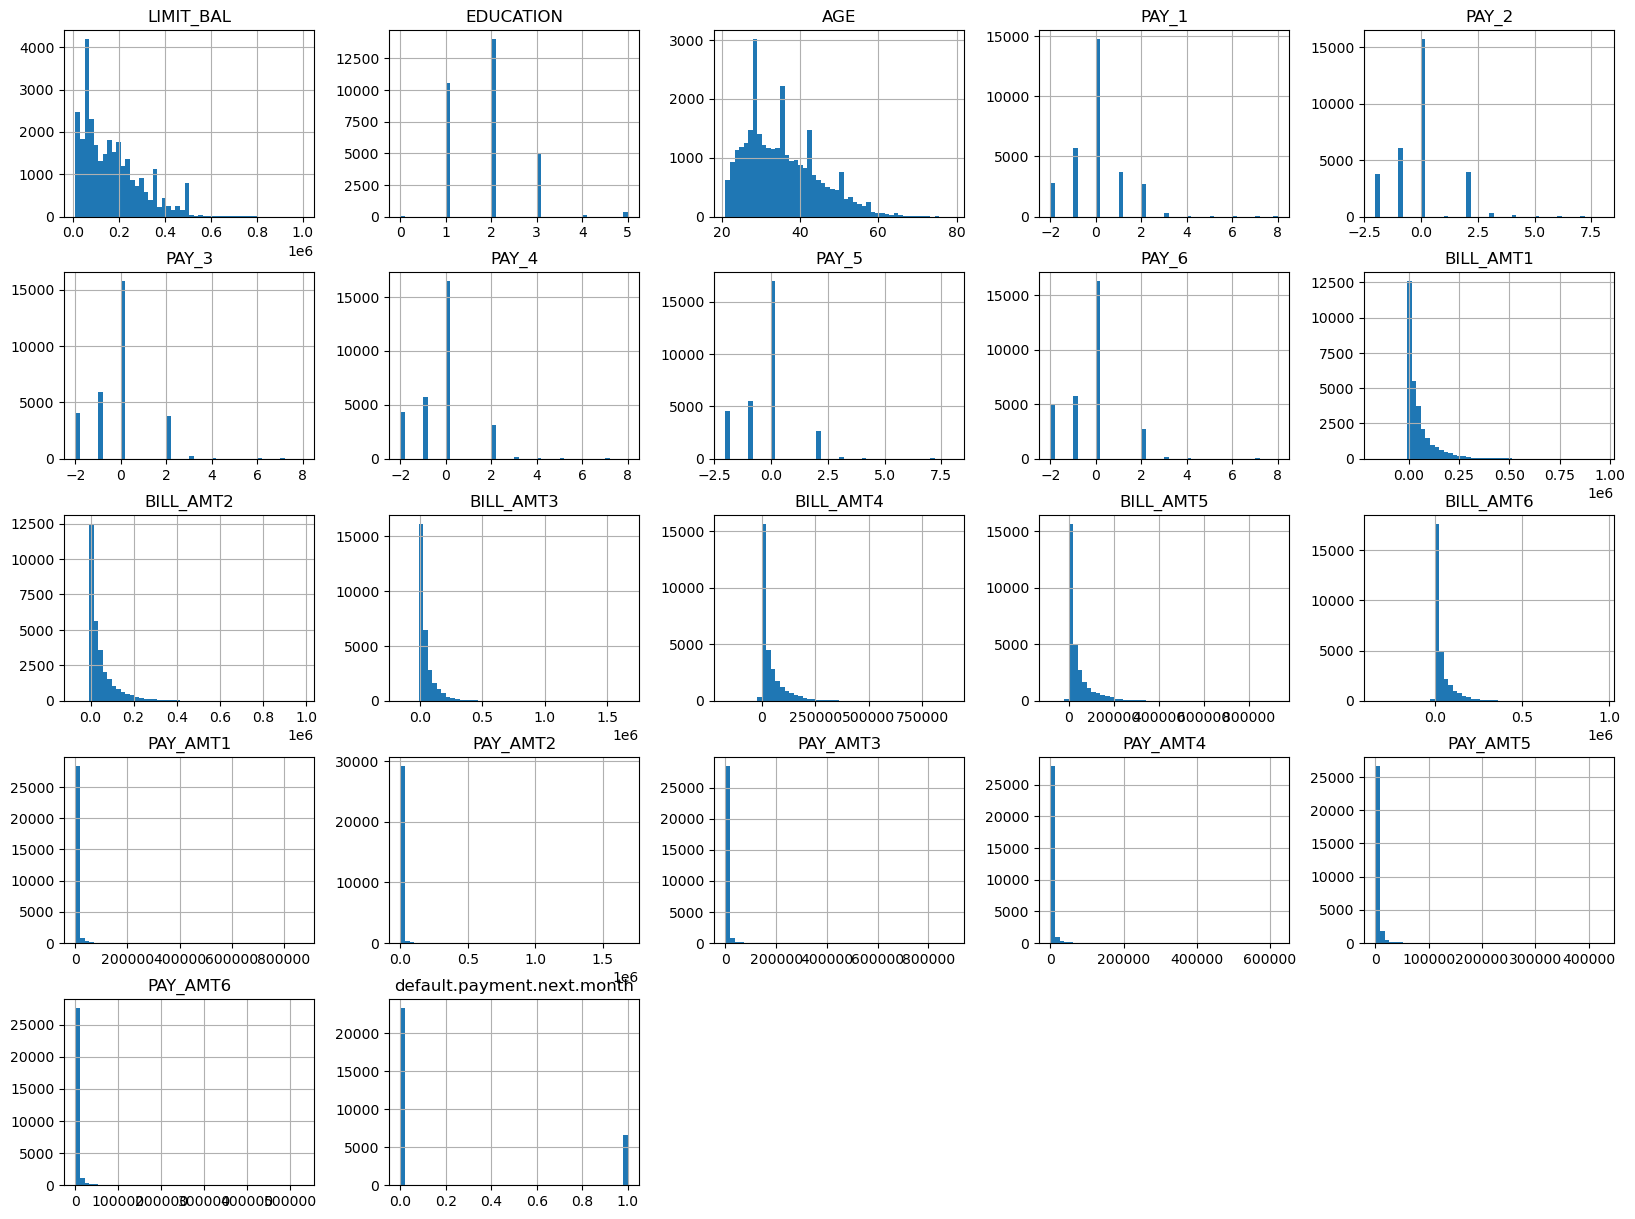

In [7]:
default_df.hist(bins=50, figsize=(20, 15))

- Judging by the histograms, we can see that the symmetry of ID shows that this feature is not valuable in determining the default.payment.next.month
- Conversely, the fact that LIMIT_BAL and Age are skewed shows that there may be a pattern for those with a certain age range and limit-balance just by looking at the histograms and may be userful information.
- It looks like the bill amounts and the pay amounts all follow the same pattern--they all have a peak and are right-skewed. Because they are exteremely similar to each other, I think this just tells us that people have an average amount that they spend and they also have an average amount that the pay--although this amount may differ sometimes, it does not dramatically change often.

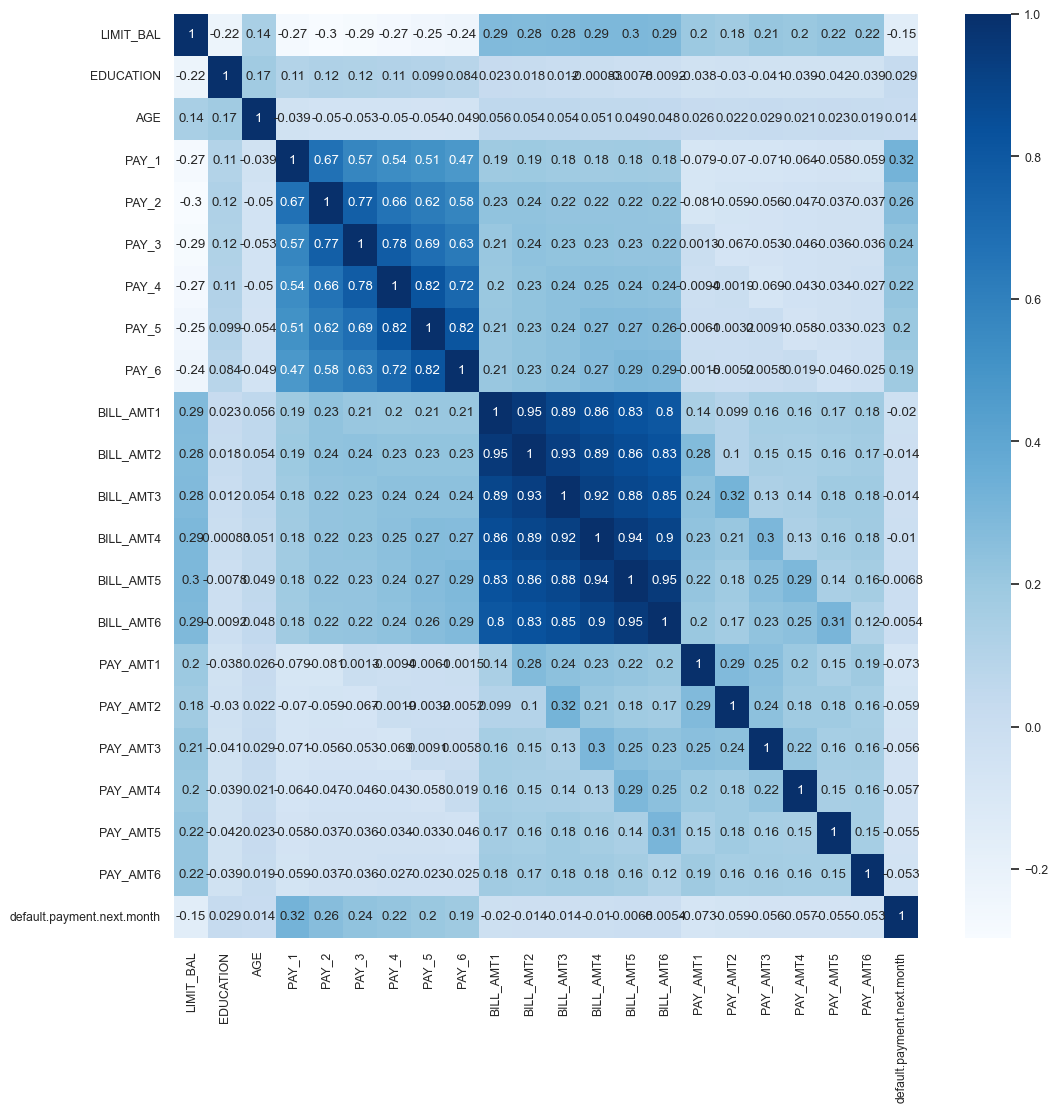

In [8]:
cor = default_df.corr()
plt.figure(figsize=(12, 12))
sns.set(font_scale=0.8)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

- Looking at this correlation map confirms my observations regarding the the correlation of PAY_0...PAY_6 and BILL_AMT1...BILL_AMT6. Because these have high correlation within each other, we may need to remove some of these to reduce redundancy and prevent multicollinearity.

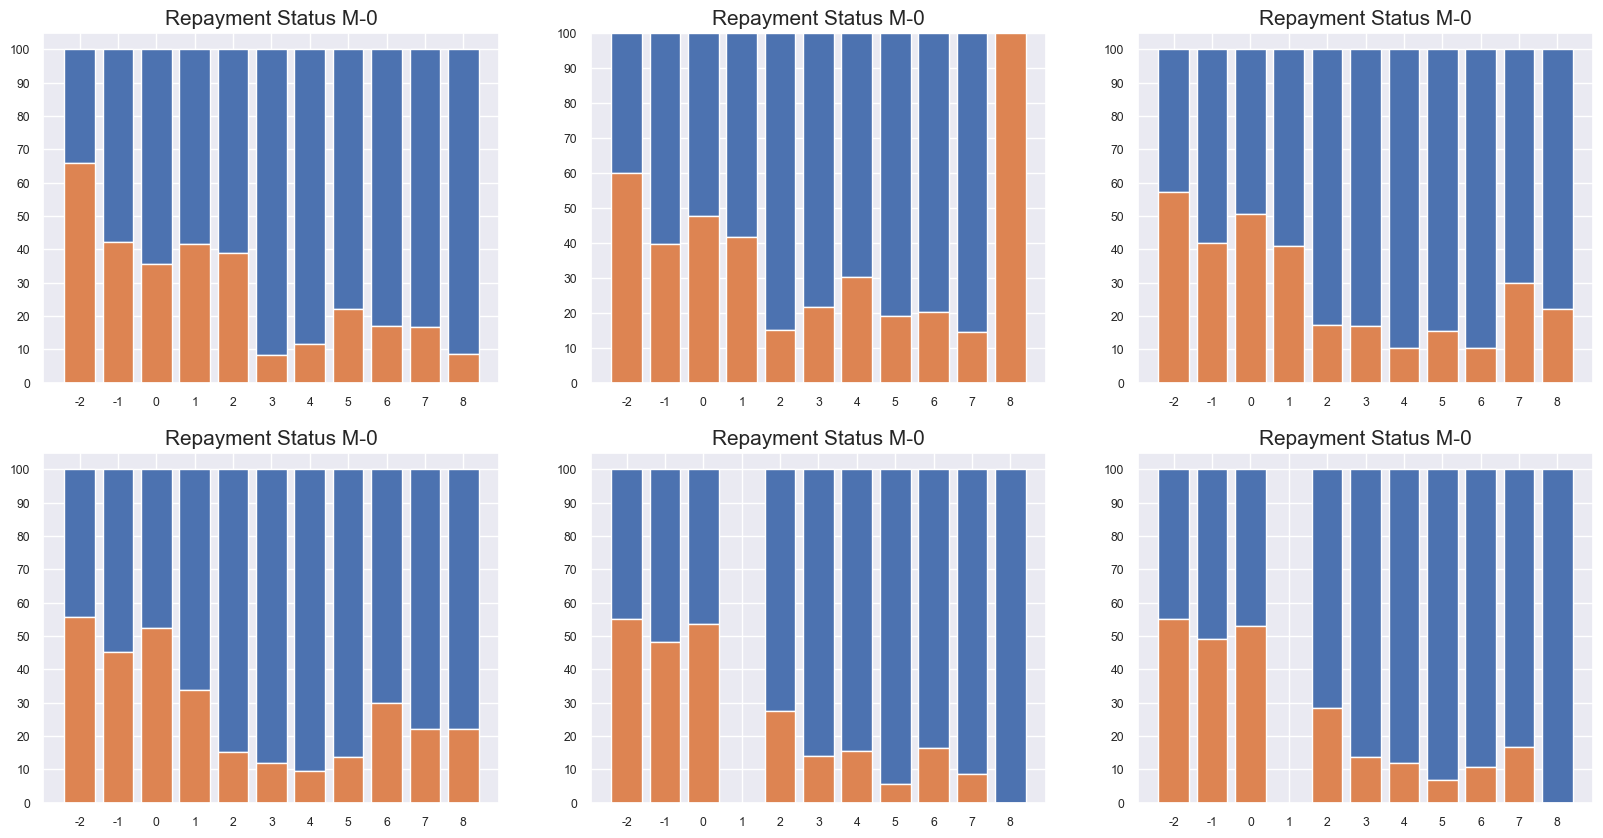

In [9]:
fig,axs = plt.subplots(2, 3, figsize= (20, 10))

def plotstuff(featureDF, ax):
    ind = sorted(featureDF.unique())
    pay_0 = (featureDF[default_df['default.payment.next.month'] == 0].value_counts(normalize=True))
    pay_1 = (featureDF[default_df['default.payment.next.month'] == 1].value_counts(normalize=True))
    for i in pay_0.index:
        if i not in pay_1.index:
            pay_1[i]=0
    for i in pay_1.index:
        if i not in pay_0.index:
            pay_0[i]=0    
    total = pay_0.values+pay_1.values
    pay_0_prop = np.true_divide(pay_0, total)*100
    pay_1_prop = np.true_divide(pay_1, total)*100
    ax.bar(ind, pay_1_prop, bottom=pay_0_prop, label='1')
    ax.bar(ind, pay_0_prop, label='0')
    ax.set_title("Repayment Status M-0", fontsize=15)

plotstuff(default_df.PAY_1, axs[0,0])
plotstuff(default_df.PAY_2, axs[0,1])
plotstuff(default_df.PAY_3, axs[0,2])
plotstuff(default_df.PAY_4, axs[1,0])
plotstuff(default_df.PAY_5, axs[1,1])
plotstuff(default_df.PAY_6, axs[1,2])

for ax in axs.flat:
    ax.set_xticks(sorted(default_df.PAY_1.unique()))
    ax.set_xticklabels(sorted(default_df.PAY_1.unique()))
    ax.set_yticks(np.arange(0, 110, 10))
    ax.set_yticklabels(np.arange(0, 110, 10))

plt.show()

In the above plots where orange = not defaulting and blue = defaulting, we see that the orange bar decreases and the blue bar increases, meaning that the sooner people pay their credit card balance, the less likely they are to default. 

<!-- END QUESTION -->

<br><br>

## 4. Feature engineering <a name="4"></a>
<hr>

In [10]:
def createAverageMonthlyBillIncrease(df):
    return (df['BILL_AMT6'] - df['BILL_AMT1']) / 5

def createAverageMonthlyBill(df):
    return (df['BILL_AMT6'] + df['BILL_AMT5'] + df['BILL_AMT4'] + df['BILL_AMT3'] + df['BILL_AMT2'] + df['BILL_AMT1']) / 6

def createAverageMonthlyPayIncrease(df):
    return (df['PAY_AMT6'] - df['PAY_AMT1']) / 5

def createAverageMonthlyPay(df):
    return (df['PAY_AMT6'] + df['PAY_AMT5'] + df['PAY_AMT4'] + df['PAY_AMT3'] + df['PAY_AMT2'] + df['PAY_AMT1']) / 6

tempDF_train = train_df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
tempDF_test = test_df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]

def replace_negative(x):
    return x if x >= 0 else 0

for column in tempDF_train.columns:
    tempDF_train[column] = tempDF_train[column].apply(replace_negative)
    
for column in tempDF_test.columns:
    tempDF_test[column] = tempDF_test[column].apply(replace_negative)
    
averageDelayTrain = (tempDF_train['PAY_1'] + tempDF_train['PAY_2'] + tempDF_train['PAY_3'] + tempDF_train['PAY_4'] +  tempDF_train['PAY_5'] +  tempDF_train['PAY_6']) / 6
averageDelayTest = (tempDF_test['PAY_1'] + tempDF_test['PAY_2'] + tempDF_test['PAY_3'] + tempDF_test['PAY_4'] +  tempDF_test['PAY_5'] +  tempDF_test['PAY_6']) / 6

train_df = train_df.assign(average_monthly_bill_increase = createAverageMonthlyBillIncrease(train_df),
                           average_months_delay = averageDelayTrain,
                           average_monthly_bill = createAverageMonthlyBill(train_df),
                           average_monthly_pay_increase = createAverageMonthlyPayIncrease(train_df),
                           average_monthly_pay = createAverageMonthlyPay(train_df)
                          )
test_df = test_df.assign(average_monthly_bill_increase = createAverageMonthlyBillIncrease(test_df),
                           average_months_delay = averageDelayTest,
                           average_monthly_bill = createAverageMonthlyBill(test_df),
                           average_monthly_pay_increase = createAverageMonthlyPayIncrease(test_df),
                           average_monthly_pay = createAverageMonthlyPay(test_df)
                          )
test_df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,average_monthly_bill_increase,average_months_delay,average_monthly_bill,average_monthly_pay_increase,average_monthly_pay
25665,40000.0,2,2,2,26,-1,0,0,0,-1,...,0.0,22373.0,680.0,10000.0,0,-2058.8,0.000000,21617.166667,1740.0,5892.166667
16464,80000.0,2,3,1,59,0,0,0,0,0,...,2000.0,1603.0,1903.0,2006.0,0,-5238.4,0.000000,58270.166667,-241.2,2138.333333
22386,170000.0,2,1,2,30,2,2,2,2,2,...,0.0,13000.0,5500.0,1000.0,1,3002.4,2.000000,162134.833333,-1160.0,5466.666667
10149,200000.0,2,2,1,41,-2,-2,-2,-2,-2,...,0.0,0.0,0.0,0.0,1,-4714.0,0.000000,4050.833333,-148.4,123.666667
8729,50000.0,1,2,1,43,0,0,0,0,0,...,331.0,341.0,356.0,330.0,0,280.6,0.000000,8925.166667,-162.0,608.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17548,60000.0,2,2,1,48,0,0,0,0,0,...,1400.0,600.0,1000.0,1000.0,1,-6702.2,0.000000,39950.666667,-200.0,1350.000000
11459,310000.0,1,2,1,43,-1,-1,-1,-1,-1,...,2018.0,2505.0,816.0,3052.0,0,-825.8,0.000000,2502.500000,72.2,2190.333333
6608,10000.0,2,2,2,22,0,0,0,0,0,...,1000.0,1535.0,0.0,1000.0,0,767.8,0.333333,8336.833333,-56.8,1017.000000
2414,30000.0,1,2,1,38,1,-1,-1,-1,-1,...,2713.0,0.0,0.0,0.0,1,0.0,0.166667,1443.333333,-456.2,1443.333333


## Preprocessing and transformations <a name="5"></a>
<hr>

| Feature | Transformation | Explanation
| --- | ----------- | ----- |
| ID | drop | Based on histograms above, ID does not provide valuable information |
| AGE | scaling | numerical feature that needs to be scaled |
| LIMIT_BAL | scaling | numerical feature that needs to be scaled |
| BILL_AMT1...BILL_AMT6 | scaling | numerical feature that needs to be scaled |
| PAY_AMT1...PAY_AMT6 | scaling | numerical feature that needs to be scaled |
| average_monthly_bill_increase | scaling | numerical feature that needs to be scaled |
| average_monthly_pay_increase | scaling | numerical feature that needs to be scaled |
| average_delay | scaling | represents the number of months that was delayed. | 
| PAY_0...PAY_6 | none | -2 = no balance due, -1 = pay duly, 0-8 = pay months due |
| EDUCATION | none | already "encoded" to appropriate order (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown) |
| MARRAGE | one hot encoder | needs to be one-hot encoded|
| SEX | one hot encoder  |needs to be one-hot encoded | 

In [11]:
numeric_features = ["AGE", "LIMIT_BAL", "average_monthly_bill_increase", "average_monthly_pay_increase", "average_months_delay", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
ohe_features = ["MARRIAGE", "SEX"]
passthrough_features = ["PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6", "EDUCATION"]
target = "default.payment.next.month"

In [12]:
X_train_big = train_df.drop(columns=[target])
y_train_big = train_df[target]

X_test = test_df.drop(columns=[target])
y_test = test_df[target]

X_train, X_valid, y_train, y_valid = train_test_split(
    train_df, y_train_big, test_size=0.3, random_state=123
)

In [13]:
preprocessor = make_column_transformer(    
    (StandardScaler(), numeric_features),
    (OneHotEncoder(), ohe_features),
    ("passthrough", passthrough_features),
)
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['AGE', 'LIMIT_BAL',
                                  'average_monthly_bill_increase',
                                  'average_monthly_pay_increase',
                                  'average_months_delay', 'BILL_AMT1',
                                  'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
                                  'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                                  'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4',
                                  'PAY_AMT5', 'PAY_AMT6']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['MARRIAGE', 'SEX']),
                                ('passthrough', 'passthrough',
                                 ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                                  'PAY_6', 'EDUCATION'])])

In [14]:
transformed_df = pd.DataFrame(preprocessor.fit_transform(X_train))
transformed_df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-1.137328,-0.902800,0.346486,-0.048343,0.091165,-0.610492,-0.575924,-0.558412,-0.538186,-0.515315,...,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0
1,1.028380,-0.902800,0.453954,-0.030871,-0.469324,-0.417156,-0.457067,-0.472707,-0.381819,-0.276778,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.595901,-0.210070,0.135628,0.043384,-0.469324,0.270335,0.133365,0.185644,0.269021,0.368836,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,0.703524,0.482659,-0.428976,-0.031221,-0.469324,0.567234,0.589105,0.634627,0.246143,0.329562,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4,0.920095,0.097809,0.035810,0.020758,-0.469324,-0.410193,-0.688632,-0.669966,-0.673286,-0.548879,...,0.0,0.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14695,-0.271045,0.251749,0.197685,-0.071406,-0.469324,-0.572156,-0.635457,-0.672676,-0.673286,-0.651292,...,0.0,0.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1.0
14696,0.162097,-0.210070,-0.375103,-0.021786,-0.469324,1.173051,1.216876,1.345578,1.495201,1.138052,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14697,-0.595901,0.559629,0.269431,0.012808,-0.469324,-0.690041,-0.688660,-0.383403,-0.673286,-0.474334,...,0.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
14698,-1.245614,-1.056740,0.346324,0.165686,0.651655,-0.369226,-0.360871,-0.338802,-0.272279,-0.232743,...,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0


## Baseline model
<hr>

In [15]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [16]:
classifier = DummyClassifier(strategy="most_frequent")

# Perform 5-fold cross-validation
cv = cross_validate(classifier, X_train, y_train, cv=5, return_train_score=True)

# Create a DataFrame from the cross-validation results
dummy_df = pd.DataFrame(cv)
dummy_df

pipeline_dummy = make_pipeline(preprocessor, classifier)

results_dict = {}
results_dict["Dummy classifier"] = mean_std_cross_val_scores(
    pipeline_dummy, X_train, y_train, return_train_score=True, scoring="recall"
)

display(pd.DataFrame(results_dict).T)

,fit_time,score_time,test_score,train_score
Dummy classifier,0.007 (+/- 0.001),0.003 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)


## Linear models <a name="7"></a>
<hr>

,fit_time,score_time,test_score,train_score
0,0.045383,0.003648,0.290715,0.280655
1,0.047092,0.003447,0.290715,0.281797
2,0.048036,0.004278,0.284627,0.286367
3,0.046337,0.003627,0.268293,0.301104
4,0.043405,0.003885,0.289634,0.276742


              precision    recall  f1-score   support

 non-default       0.96      0.82      0.89     13342
     default       0.29      0.69      0.40      1358

    accuracy                           0.81     14700
   macro avg       0.62      0.76      0.65     14700
weighted avg       0.90      0.81      0.84     14700



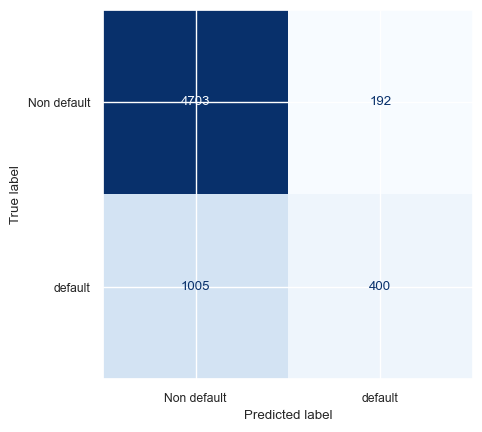

In [17]:
lr = LogisticRegression()
pipe = make_pipeline(preprocessor, lr)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_train)

disp = ConfusionMatrixDisplay.from_estimator(         # create a confusion matrix display object 
    pipe,
    X_valid,                 # validation data set 
    y_valid,
    display_labels=["Non default", "default"],       # non fraud transaction = negative and fraud transactions = positive
    values_format="d",       # represent the numbers as integers
    cmap=plt.cm.Blues,       # set the color map for the display to "Blues"
    colorbar=False,          # remove the color bar that usually appears next to the confusion matrix
);

scores = cross_validate(pipe, X_train, y_train, return_train_score=True, scoring='recall')
display(pd.DataFrame(scores))

print(classification_report(y_pred, y_train, target_names=["non-default", "default"]))

### Because I believe that it is more important to identify the true positives (user defaulted and model correctly predicted)
## I will be using recall as our scoring metric

RECALL EQUATION:
    
TP = TP / ( TP + TN )

In [18]:
scores_dict = {
    "C": 10.0 ** np.arange(-4, 6, 1),  # Create C values between 10^-4 and 10^5 (inclusive)
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
}
for C in scores_dict["C"]:
    lr = LogisticRegression(C=C)
    pipe = make_pipeline(preprocessor, lr)
    scores = mean_std_cross_val_scores(pipe, X_train, y_train, return_train_score=True, scoring='recall')
    scores_dict["mean_train_scores"].append(scores["train_score"])
    scores_dict["mean_cv_scores"].append(scores["test_score"])

results_df = pd.DataFrame(scores_dict)
results_df

,C,mean_train_scores,mean_cv_scores
0,0.0001,0.031 (+/- 0.003),0.030 (+/- 0.009)
1,0.0010,0.221 (+/- 0.008),0.221 (+/- 0.015)
2,0.0100,0.274 (+/- 0.008),0.274 (+/- 0.009)
3,0.1000,0.284 (+/- 0.009),0.283 (+/- 0.009)
4,1.0000,0.285 (+/- 0.009),0.285 (+/- 0.010)
5,10.0000,0.285 (+/- 0.009),0.285 (+/- 0.010)
6,100.0000,0.285 (+/- 0.009),0.284 (+/- 0.010)
7,1000.0000,0.285 (+/- 0.009),0.284 (+/- 0.010)
8,10000.0000,0.285 (+/- 0.009),0.284 (+/- 0.010)
9,100000.0000,0.285 (+/- 0.009),0.284 (+/- 0.010)


In [19]:
param_grid = {
    'logisticregression__max_iter': [10, 100, 1000, 10000],
    'logisticregression__C': 10.0 ** np.arange(-1.5, 2, 0.5)
}
pipe_lr = make_pipeline(preprocessor, LogisticRegression(solver='liblinear'))
grid_search = GridSearchCV(pipe_lr, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_max_features = grid_search.best_params_['logisticregression__max_iter']
best_C = grid_search.best_params_['logisticregression__C']
best_score = grid_search.best_score_

pipeline_lr = make_pipeline(preprocessor, LogisticRegression(C=grid_search.best_params_['logisticregression__C'], max_iter=grid_search.best_params_['logisticregression__max_iter']))
pipeline_lr.fit(X_train, y_train)

results_dict["Logistic Regression"] = mean_std_cross_val_scores(
    pipeline_lr, X_train, y_train, return_train_score=True, scoring="recall"
)
display(pd.DataFrame(results_dict).T)

,fit_time,score_time,test_score,train_score
Dummy classifier,0.007 (+/- 0.001),0.003 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
Logistic Regression,0.011 (+/- 0.000),0.003 (+/- 0.000),0.303 (+/- 0.012),0.304 (+/- 0.010)


In [20]:
y_pred_lower_threshold = pipeline_lr.predict_proba(X_valid)[:, 1] > 0.4
print(classification_report(y_valid, y_pred_lower_threshold))

pr_dict = {"threshold": [], "precision": [], "recall": [], "f1 score": []}
thresholds = np.arange(0.0, 1.0, 0.1)
for threshold in thresholds:
    preds = pipeline_lr.predict_proba(X_valid)[:, 1] > threshold
    pr_dict["threshold"].append(threshold)
    pr_dict["precision"].append(precision_score(y_valid, preds))
    pr_dict["recall"].append(recall_score(y_valid, preds))
    pr_dict["f1 score"].append(f1_score(y_valid, preds))
pd.DataFrame(pr_dict)

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      4895
           1       0.60      0.40      0.48      1405

    accuracy                           0.81      6300
   macro avg       0.72      0.66      0.68      6300
weighted avg       0.79      0.81      0.79      6300



,threshold,precision,recall,f1 score
0,0.0,0.223016,1.000000,0.364698
1,0.1,0.248946,0.924555,0.392269
2,0.2,0.434692,0.592171,0.501356
3,0.3,0.531463,0.498932,0.514684
4,0.4,0.604899,0.404270,0.484642
5,0.5,0.674230,0.296085,0.411474
6,0.6,0.710468,0.227046,0.344121
7,0.7,0.736655,0.147331,0.245552
8,0.8,0.762238,0.077580,0.140827
9,0.9,0.683333,0.029181,0.055973


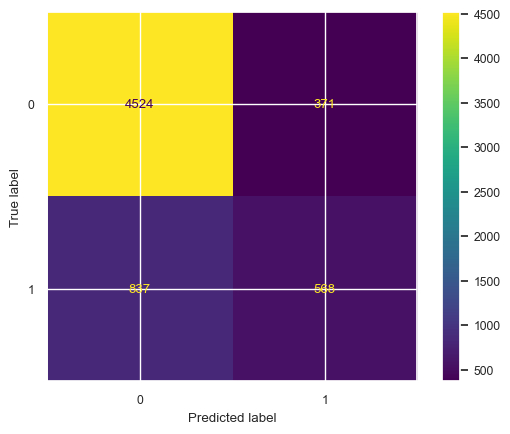

In [21]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_valid, y_pred_lower_threshold)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

From the table we can see that the test and train scores for recall in the logistic regression model are relatively consistent, although the recall score is relatively low it is much better than the zero that comes from the dumby classiffier. It doesn't seem like there is any over-fitting or under-fitting involved after looking at the test-score and this gives a decent baseline. We use recall because there is a 77 percent imbalance in the target class and in context we are more worried about true positives (defaulters) then accuracy.

As a general rule of thumb changing the threshold to be lower will cause the number of true positives to be higher and it might be worth doing so if the end goal is to catch as many true positives as possible. This can be seen by the table that displays thresholds from 0 to 0.9 and the confusion matrix representing a threshold of 0.4, which contains more true positives than the threshold of 0.5.

## Different models <a name="8"></a>
<hr>

In [22]:
from sklearn.ensemble import RandomForestClassifier
pipe_rf = make_pipeline(
    preprocessor, RandomForestClassifier()
)
results_dict["Random forests"] = mean_std_cross_val_scores(
    pipe_rf, X_train, y_train, return_train_score=True, scoring="recall"
)

from sklearn.svm import SVC

pipe_svc = make_pipeline(
    preprocessor, SVC()
)
results_dict["SVC"] = mean_std_cross_val_scores(
    pipe_svc, X_train, y_train, return_train_score=True, scoring="recall"
)

from catboost import CatBoostClassifier
pipe_catboost = make_pipeline(
    preprocessor, CatBoostClassifier(verbose=False)
)
results_dict["Catboost"] = mean_std_cross_val_scores(
    pipe_catboost, X_train, y_train, return_train_score=True, scoring="recall"
)

pd.DataFrame(results_dict).T

,fit_time,score_time,test_score,train_score
Dummy classifier,0.007 (+/- 0.001),0.003 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
Logistic Regression,0.011 (+/- 0.000),0.003 (+/- 0.000),0.303 (+/- 0.012),0.304 (+/- 0.010)
Random forests,2.230 (+/- 0.016),0.036 (+/- 0.001),0.376 (+/- 0.020),0.999 (+/- 0.001)
SVC,3.110 (+/- 0.042),0.749 (+/- 0.030),0.350 (+/- 0.017),0.368 (+/- 0.008)
Catboost,3.376 (+/- 0.047),0.018 (+/- 0.001),0.380 (+/- 0.027),0.514 (+/- 0.006)


This shows that are best base models are either the Catboost or Random Forest classifiers. There is some definite over-fitting involved with Random forest seeing that there is such a large gap between the train and test-score for that model. This isn't as evident within the Catboost model, so it might make a better candidate for the final model.

<!-- END QUESTION -->

<br><br>

## Feature selection
<hr>

In [23]:
from sklearn.feature_selection import RFECV

rfe_cv=RFECV(LogisticRegression(C=grid_search.best_params_['logisticregression__C'], max_iter=grid_search.best_params_['logisticregression__max_iter']), cv=10)
rfe_cv.fit(X_train_big, y_train_big)
print(rfe_cv.support_)
print(X_train_big.columns[rfe_cv.support_])

[ True False False False False False False False False False False False
 False False False False False  True  True  True  True False False False
 False False False  True]
Index(['LIMIT_BAL', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4',
       'average_monthly_pay'],
      dtype='object')


In [24]:
results_dict["Logistic Regression"] = mean_std_cross_val_scores(
    pipeline_lr, X_train, y_train, return_train_score=True, scoring="recall"
)

models=[RandomForestClassifier(max_depth=None, min_samples_split=6, n_estimators=900), 
        CatBoostClassifier(max_depth=4, n_estimators=100, verbose=False), 
        SVC(kernel='rbf', gamma=0.1, C=3.0),
        LogisticRegression(C=grid_search.best_params_['logisticregression__C'], max_iter=grid_search.best_params_['logisticregression__max_iter'])]
modelName=['Random Forest', 'CatBoost', 'SVC', 'Logistic Regression']
i = 0
resultsRFE = {}
for model in models:
    rfe_pipe = make_pipeline(
        preprocessor,
        RFECV(LogisticRegression(C=grid_search.best_params_['logisticregression__C'], max_iter=grid_search.best_params_['logisticregression__max_iter']), cv=10),
        model)
    resultsRFE[modelName[i]] = mean_std_cross_val_scores(rfe_pipe, X_train, y_train, return_train_score=True, scoring="recall")
    i=i+1

pd.DataFrame(resultsRFE).T

,fit_time,score_time,test_score,train_score
Random Forest,20.763 (+/- 0.179),0.304 (+/- 0.005),0.386 (+/- 0.017),0.910 (+/- 0.005)
CatBoost,1.714 (+/- 0.040),0.005 (+/- 0.001),0.381 (+/- 0.015),0.431 (+/- 0.006)
SVC,5.203 (+/- 0.155),0.864 (+/- 0.029),0.352 (+/- 0.024),0.485 (+/- 0.008)
Logistic Regression,1.558 (+/- 0.029),0.004 (+/- 0.000),0.307 (+/- 0.013),0.308 (+/- 0.007)


After incorporating our feature selection object into our pipeline and running cross validation on the various models, we were able to conclude that the feature selection did not positively impact the train and test scores. Without using feature selection, our models achieved slightly higher scores (~0.002-~0.004). Therefore, we decided to omit this tool in the next exercises.

<!-- END QUESTION -->

<br><br>

## Hyperparameter optimization <a name="10"></a>
<hr>

In [25]:
resultsOptimization={}

param_dist_cat = {
    'catboostclassifier__max_depth': [3,4,5],
    'catboostclassifier__n_estimators':[100, 200, 300]
}
cat_random_search = RandomizedSearchCV(pipe_catboost, param_distributions=param_dist_cat, cv=5, scoring="recall", random_state=123, n_jobs=-1)
cat_random_search.fit(X_train, y_train)

cat_best_max_depth = cat_random_search.best_params_['catboostclassifier__max_depth']
cat_best_n_estimators = cat_random_search.best_params_['catboostclassifier__n_estimators']
best_score_cat = cat_random_search.best_score_
print(f"Best Max Depth: {cat_best_max_depth}")
print(f"Best n estimators: {cat_best_n_estimators}")
print(f"Best Score: {best_score_cat}")

Best Max Depth: 4
Best n estimators: 100
Best Score: 0.38774965660615507


In [26]:
param_dist_rf = {
    'randomforestclassifier__max_depth': [None, 3, 5, 10, 15, 20],
    'randomforestclassifier__min_samples_split': [2, 4, 6, 8, 10],
    'randomforestclassifier__n_estimators': [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}
rf_random_search = RandomizedSearchCV(pipe_rf, param_distributions=param_dist_rf, cv=5, scoring="recall", random_state=123, n_jobs=-1)
rf_random_search.fit(X_train, y_train)

rf_best_max_depth = rf_random_search.best_params_['randomforestclassifier__max_depth']
rf_best_samples_split = rf_random_search.best_params_['randomforestclassifier__min_samples_split']
rf_best_n_estimators = rf_random_search.best_params_['randomforestclassifier__n_estimators']
best_score_rf = rf_random_search.best_score_
print(f"Best Max Depth: {rf_best_max_depth}")
print(f"Best Min sample split: {rf_best_samples_split}")
print(f"Best n estimators: {rf_best_n_estimators}")
print(f"Best Score: {best_score_rf}")

Best Max Depth: None
Best Min sample split: 6
Best n estimators: 900
Best Score: 0.38714129264580316


In [27]:
param_dist_svc = {
    'svc__kernel': ['linear', 'rbf'],
    "svc__gamma": [0.001, 0.01, 0.1, 1.0, 10, 100],
    "svc__C": np.linspace(2, 3, 6),
}

svc_random_search = RandomizedSearchCV(pipe_svc, param_distributions=param_dist_svc, cv=5, scoring="recall", random_state=123, n_jobs=-1)
svc_random_search.fit(X_train, y_train)

svc_best_kernel = svc_random_search.best_params_['svc__kernel']
svc_best_gamma = svc_random_search.best_params_['svc__gamma']
svc_best_C = svc_random_search.best_params_['svc__C']
best_score_svc = svc_random_search.best_score_
print(f"Best kernel: {svc_best_kernel}")
print(f"Best gamma: {svc_best_gamma}")
print(f"Best C: {svc_best_C}")
print(f"Best Score: {best_score_svc}")

Best kernel: rbf
Best gamma: 0.1
Best C: 3.0
Best Score: 0.35210908787170064


## Results on the test set 
<hr>

In [32]:
final_pipe = make_pipeline(
    preprocessor, RandomForestClassifier(max_depth=None, min_samples_split=6, n_estimators=900)
)

final_pipe.fit(X_train, y_train)
test_score = final_pipe.score(X_test, y_test)

display(mean_std_cross_val_scores(
    final_pipe, X_train, y_train, return_train_score=True, scoring="recall"
))

print("Final test score: ",test_score)

fit_time       19.735 (+/- 0.435)
score_time      0.314 (+/- 0.067)
test_score      0.388 (+/- 0.017)
train_score     0.908 (+/- 0.003)
dtype: object

Final test score:  0.8171111111111111


In [33]:
sample = test_df.sample()
X_sample = sample.drop(columns=[target])
y_sample = sample[target]
display(sample)
print("Predicted default.payment.next.month: ",final_pipe.predict(X_sample))

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,average_monthly_bill_increase,average_months_delay,average_monthly_bill,average_monthly_pay_increase,average_monthly_pay
6551,260000.0,2,2,2,27,0,0,0,0,0,...,10000.0,10000.0,8938.0,2000.0,1,-2155.0,0.0,25249.5,-200.0,6156.333333


Predicted default.payment.next.month:  [0]


Our results are reflective of scores that were produced from our training data. Previously, the RandomForestClassifier achieved a recall score. We chose to go with recall score because we believe that correctly identifying the amount of true positives is more important than predicting overall accuracy. 

We were able to correctly determine the whether or not this specific sample would default or not. However, we do not think this specific example is representative towards the overall performance of the model. This is because the sample was supposed to be a 0, and not a 1. Our model does extremely well in identifying if someone WILL pay their credit card (not default) versus those who will not (will default). This will be hard because the data is more populated with non-defaulters versus defaulters. Therefore, we can trust our model (for the most part) to correctly predict non-defaulters, but we cannot trust our model in correctly predicting defaulters.

<!-- END QUESTION -->

<br><br>

## Summary of results 
<hr>

| questions | recall_cv_test_scores| Summary
| --- | ----------- | ----- |
| Base-Logistic-Regression | 0.285 | Good baseline that just needed to be better than the dummy-classifier | 
| Optimized-Logistic-Regression | 0.303 | Better than the original, but stil the score is still quite low |
| Base-Random-Forest | 0.380 | Much better than our Optimized-LogistcRegression model|
| Optimized-Random-Forest | 0.387 | The best model in terms of test-score |
| Base-CatBoost | 0.380 | Matches the base random Forest, but with a higher std value |
| Optimized-CatBoost | 0.381 | Fairly good model, comes in second place to the optimized random Forest |
| Base-SVC | 0.350 | Worse than the Random-Forest and Random-CatBoost both versions |
| Optimized-SVC | 3.52 | Worse than the Random-Forest and Random-CatBoost both versions | 

Concluding remarks:
- Although the Random Forest Classifier is the best model there was a problem with over-fitting that may present issues.
- The mean_std_cv recall scores for all the different piplines is pretty low no matter how you look at it, so I wouldn't consider this a good option for    deployment.
- To improve the model I think that the best option would be to try some more feature engineering to better analyze the importance of features and their corralation and attempt ensemble modeling to take adavantage of stacking models.
- There are also many hyper-parameters and having a better understanding of which ones to focus on for specific tuning may be helpful.

Final Metrics: 0.387 recall_cv_test_scores 

<br><br>